## SRJ - GS state

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity






def ags_exact(symbols, coordinates, electrons, orbitals, adapt_it, shots = None):
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method="pyscf")
    print(H)
    hf_state = qchem.hf_state(electrons, qubits)
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, active_electrons, qubits, H):
        #print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        print(qml.PauliX(i) for i in np.nonzero(hf_state)[0])
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                #print('Exc. dealing right now is', ash_excitation[i])
                #print('The params that are going in', params[i])
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                #print('Single Exc. dealing right now is', ash_excitation[i])
                #print('Single exc params that are going in', params[i])
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    

    
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    print('Total excitations are', len(operator_pool))
    states = [hf_state]
    params = np.zeros(len(ash_excitation), requires_grad=True) 
    z1state = []

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            #print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        #print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value


        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation

        params = np.append(params, 0.0)  #Parameters initialization



        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = 1e-12, options = {'disp': False, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)


        ostate = new_state(hf_state, ash_excitation, params)
        #print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        states.append(ostate)
        
    return gs_state, params, ash_excitation

## So if you want the state, return the ostate and not states




## Edited code

In [2]:
import os
from time import time
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy



def inite(elec,orb):
    config=[]
    list1=[]
    #singles
    for x in range(elec):
        count=orb-elec
        while (count<orb):
            for e in range(elec):
                if x==e:
                    if x%2==0:
                        config.append(count)
                        count=count+2
                    else:
                        config.append(count+1)
                        count=count+2
                else:
                    config.append(e)
                
            list1.append(config)
            config=[]
    #doubles
    for x in range(elec):
        for y in range(x+1,elec):
            count1=orb-elec
            count2=orb-elec
            for count1 in range(elec, orb, 2):
                for count2 in range(elec, orb, 2):
                    cont=0
                    if count1==count2:
                        if (x%2)!=(y%2):
                            cont=1
                    else:
                        cont=1
                    if (x%2)==(y%2) and count2<count1:
                        cont=0
                    if cont==1:    
                        for e in range(elec):
                            if x==e:
                                if x%2==0:
                                    config.append(count1)
                                else:
                                    config.append(count1+1)
                            elif y==e:
                                if y%2==0:
                                    config.append(count2)
                                else:
                                    config.append(count2+1)
                            else:
                                config.append(e)

                        list1.append(config)
                        config=[]
    return list1

def ee_exact(symbols, coordinates, electrons, charge,params,ash_excitation, shots=0):

    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method='pyscf')
    hf_state = qml.qchem.hf_state(electrons, qubits)
    print('HF state:', hf_state)
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
    wires=range(qubits)

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)
    list1 = inite(electrons,qubits)
    values =[]
    for t in range(1):
        if shots==0:
            dev = qml.device("lightning.qubit", wires=qubits)
        else:

            dev = qml.device("lightning.qubit", wires=qubits,shots=shots)
        #circuit for diagonal part
        @qml.qnode(dev)
        def circuit_d(params, occ,wires, s_wires, d_wires, hf_state, ash_excitation):
            print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ:
                qml.X(wires=w)
            print('In diagonal terms, the starting state:', hf_state)
            #Going to include excitations here
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    print('Exc. zstate:', ash_excitation[i])
                    print('Params in zstate:', params[i])
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
                elif len(ash_excitation[i]) == 2:
                    print('Single Exc. zstate:', ash_excitation[i])
                    print('Single params in zstate:', params[i])
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #circuit for off-diagonal part
        @qml.qnode(dev)
        def circuit_od(params, occ1, occ2,wires, s_wires, d_wires, hf_state, ash_excitation):
            print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ1:
                qml.X(wires=w)
            first=-1
            for v in occ2:
                if v not in occ1:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for v in occ1:
                if v not in occ2:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    print('Exc. zstate:', ash_excitation[i])
                    print('Params in zstate:', params[i])
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
                elif len(ash_excitation[i]) == 2:
                    print('Single Exc. zstate:', ash_excitation[i])
                    print('Single params in zstate:', params[i])
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #final M matrix
        M = np.zeros((len(list1),len(list1)))
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i == j:
                    M[i,i] = circuit_d(params, list1[i], wires, s_wires, d_wires, null_state, ash_excitation)
        print("diagonal parts done")
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i!=j:
                    Mtmp = circuit_od(params, list1[i],list1[j],wires, s_wires, d_wires, null_state, ash_excitation)
                    M[i,j]=Mtmp-M[i,i]/2.0-M[j,j]/2.0
        print("off diagonal terms done")
        #ERROR:not subtracting the gs energy
        eig,evec=np.linalg.eig(M)
        values.append(np.sort(eig))
    return values

symbols  = [ 'H', 'H', 'H', 'H']
r_bohr = 1.8897259886 
coordinates = np.array([[0.0, 0.0,  0.0],
                     [0.0, 0.0, 1.0*r_bohr],
                     [0.0, 0.0, 2.0*r_bohr],
                     [0.0, 0.0, 3.0*r_bohr]])


electrons = 4
orbitals = 8
charge = 0


gs_state,params,ash_excitation = ags_exact(symbols, coordinates, electrons, orbitals, shots = None, adapt_it=20) #1 is used for params



print('The params after GS is',params)
print('GS state is', gs_state)
print('Ash excitation after gs state:', ash_excitation)



#null_state = [0, 0,0,0]
#hf_state = [1,1,0,0]
#params_exact=params

eig = ee_exact(symbols, coordinates, electrons, charge,params, ash_excitation)
print('exact eigenvalues:\n', eig)

-0.3314776478540091 * I([0, 1, 2, 3, 4, 5, 6, 7]) + 0.18136486311337868 * Z(0) + 0.005562131543288114 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + 0.005562131543288114 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + 0.08792644810341417 * Z(2) + 0.06963751217552142 * (Z(0) @ Z(2)) + 0.017266562082446573 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 0.017266562082446573 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.010290903378955305 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.010290903378955305 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.07904410972743413 * Z(4) + 0.08454049632677563 * (Z(0) @ Z(4)) + -0.33461218695471684 * Z(6) + 0.10647068976730581 * (Z(0) @ Z(6)) + 0.18136486311337868 * Z(1) + 0.12432121277101203 * (Z(0) @ Z(1)) + 0.0203912989817354 * (Y(0) @ Z(2) @ Z(3) @ Y(4)) + 0.0203912989817354 * (X(0) @ Z(2) @ Z(3) @ X(4)) + 0.039345513502593965 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.039345513502593965 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.039345513502593965 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.03934551

/Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Highest gradient excitation is [2, 3, 4, 5]
Current parameters: [-0.34549402]
Current cost: -2.1224998899999097

Current parameters: [-0.34549401]
Current cost: -2.1224998899999132

Final updated parameters: [-0.34549401]
Final cost: -2.1224998899999132
<generator object ags_exact.<locals>.new_state.<locals>.<genexpr> at 0x169a228e0>
The adapt iteration now is 1
Highest gradient excitation is [0, 3, 4, 7]
Current parameters: [-0.34549401  0.17199106]
Current cost: -2.132932679985641

Current parameters: [-0.371204    0.17451109]
Current cost: -2.1330713159332353

Current parameters: [-0.37163179  0.17455302]
Current cost: -2.133071353098797

Final updated parameters: [-0.37163179  0.17455302]
Final cost: -2.133071353098797
<generator object ags_exact.<locals>.new_state.<locals>.<genexpr> at 0x169a22740>
The adapt iteration now is 2
Highest gradient excitation is [1, 2, 5, 6]
Current parameters: [-0.37163179  0.17455303  0.17638609]
Current cost: -2.1440203206294295

Current parameters:

In [ ]:
import numpy as np

eig_computed = np.array([-2.166384079181937, -1.92726693, -1.71468018, -1.62812225, -1.62131806, -1.43740454,
         -1.32959728, -1.2815366 , -1.21465643, -1.13822683, -1.11816065,
         -1.09481363, -0.98279471, -0.92765266, -0.92532517, -0.77845597,
         -0.69762438, -0.66344991, -0.62861485, -0.56528643, -0.54948315,
         -0.4113095 , -0.34244564, -0.22455392, -0.14344842,  0.31398391,
          0.34151761])



27


## FCI for excited states

In [5]:
from pyscf import gto, scf, fci
fenergies = []
# Define the molecule (ensure atom, basis, charge, and spin are defined)
mol = gto.M(
    atom='H 0.0 0.0 0.0; H 0.0 0.0 1.0; H 0.0 0.0 2.0; H 0.0 0.0 3.0',
    #atom = 'H 0 0 0; H 0 0 0.735',
    basis='sto-3g',
    verbose=4  # Optional: Adjusts verbosity for output
)
# Perform Restricted Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()
# Set up the FCI solver
cisolver = fci.FCI(mf)
# Compute multiple FCI states (e.g., 3 lowest states)
nroots = 27
fci_energies, wavefunctions = cisolver.kernel(nroots=nroots)
# Display the computed FCI energies
print("FCI Energies for multiple states:")
for i, energy in enumerate(fci_energies):
   print(f"State {i}: {energy}")
   fenergies.append(energy)

System: uname_result(system='Darwin', node='chem177.chem.und.nodak.edu', release='24.4.0', version='Darwin Kernel Version 24.4.0: Wed Mar 19 21:17:25 PDT 2025; root:xnu-11417.101.15~1/RELEASE_ARM64_T6020', machine='arm64')  Threads 1
Python 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:19:53) [Clang 18.1.8 ]
numpy 1.26.4  scipy 1.15.1  h5py 3.12.1
Date: Tue Apr  8 12:02:39 2025
PySCF version 2.8.0
PySCF path  /Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 4
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT] 

[[3.36945283e-06 6.49030351e-03 4.81396263e-03 2.15356362e-02
  1.81996638e-03 2.86743253e-04 2.67807745e-03 3.28596612e-03
  1.45384477e-07 8.57752183e-03 3.83700641e-03 1.11678501e-02
  6.45625387e-04 1.63227361e-02 1.79251148e-02 1.07925356e-03
  2.20679844e-02 3.71982708e-02 1.07643406e-02 5.93587235e-02
  2.07425473e-03 6.41588917e-02 6.95700938e-02 1.57471079e-01
  1.15687735e-01 5.72069114e-01 5.58574715e-01]]


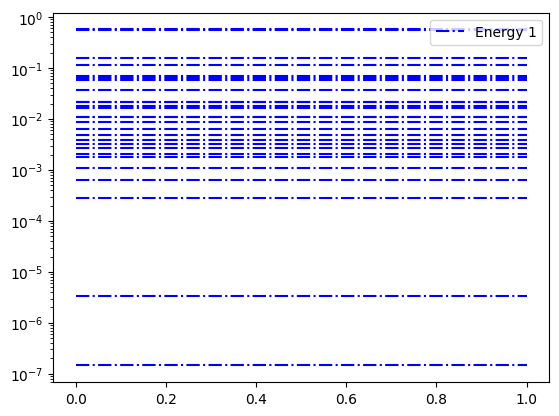

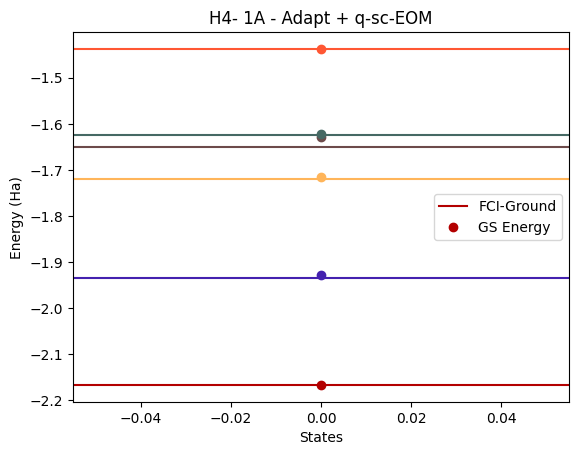

In [ ]:
import matplotlib.pyplot as plt
excited_states = np.arange(0,27,1)

error = np.array([eig_computed - fenergies])
print(error)


plt.show()

plt.axhline(y=fenergies[0], color="#b30000", linestyle='-', label='FCI-Ground')
plt.axhline(y=fenergies[1], color="#4421af", linestyle='-')
plt.axhline(y=fenergies[2], color="#ffb55a", linestyle='-')
plt.axhline(y=fenergies[3], color="#6d4b4b", linestyle='-')
plt.axhline(y=fenergies[4], color="#466964", linestyle='-')
plt.axhline(y=fenergies[5], color="#FF5733", linestyle='-')


plt.plot(0, eig_computed[0],'o', color = '#b30000', label = 'GS Energy') 
plt.plot(0, eig_computed[1], 'o', color = '#4421af')
plt.plot(0, eig_computed[2], 'o', color = '#ffb55a')
plt.plot(0, eig_computed[3], 'o', color = '#6d4b4b')
plt.plot(0, eig_computed[4], 'o', color = '#466964')
plt.plot(0, eig_computed[5], 'o', color = '#FF5733')

plt.legend()
plt.xlabel('States')
plt.ylabel('Energy (Ha)')
plt.title('H4- 1A - Adapt + q-sc-EOM')


plt.show()

## H4- 2A case

In [2]:
import os
from time import time
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy



def inite(elec,orb):
    config=[]
    list1=[]
    #singles
    for x in range(elec):
        count=orb-elec
        while (count<orb):
            for e in range(elec):
                if x==e:
                    if x%2==0:
                        config.append(count)
                        count=count+2
                    else:
                        config.append(count+1)
                        count=count+2
                else:
                    config.append(e)
                
            list1.append(config)
            config=[]
    #doubles
    for x in range(elec):
        for y in range(x+1,elec):
            count1=orb-elec
            count2=orb-elec
            for count1 in range(elec, orb, 2):
                for count2 in range(elec, orb, 2):
                    cont=0
                    if count1==count2:
                        if (x%2)!=(y%2):
                            cont=1
                    else:
                        cont=1
                    if (x%2)==(y%2) and count2<count1:
                        cont=0
                    if cont==1:    
                        for e in range(elec):
                            if x==e:
                                if x%2==0:
                                    config.append(count1)
                                else:
                                    config.append(count1+1)
                            elif y==e:
                                if y%2==0:
                                    config.append(count2)
                                else:
                                    config.append(count2+1)
                            else:
                                config.append(e)

                        list1.append(config)
                        config=[]
    return list1

def ee_exact(symbols, coordinates, electrons, charge,params,ash_excitation, shots=0):

    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method='pyscf')
    hf_state = qml.qchem.hf_state(electrons, qubits)
    print('HF state:', hf_state)
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
    wires=range(qubits)

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)
    list1 = inite(electrons,qubits)
    values =[]
    for t in range(1):
        if shots==0:
            dev = qml.device("lightning.qubit", wires=qubits)
        else:

            dev = qml.device("lightning.qubit", wires=qubits,shots=shots)
        #circuit for diagonal part
        @qml.qnode(dev)
        def circuit_d(params, occ,wires, s_wires, d_wires, hf_state, ash_excitation):
            print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ:
                qml.X(wires=w)
            print('In diagonal terms, the starting state:', hf_state)
            #Going to include excitations here
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    print('Exc. zstate:', ash_excitation[i])
                    print('Params in zstate:', params[i])
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
                elif len(ash_excitation[i]) == 2:
                    print('Single Exc. zstate:', ash_excitation[i])
                    print('Single params in zstate:', params[i])
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #circuit for off-diagonal part
        @qml.qnode(dev)
        def circuit_od(params, occ1, occ2,wires, s_wires, d_wires, hf_state, ash_excitation):
            print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ1:
                qml.X(wires=w)
            first=-1
            for v in occ2:
                if v not in occ1:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for v in occ1:
                if v not in occ2:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    print('Exc. zstate:', ash_excitation[i])
                    print('Params in zstate:', params[i])
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
                elif len(ash_excitation[i]) == 2:
                    print('Single Exc. zstate:', ash_excitation[i])
                    print('Single params in zstate:', params[i])
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #final M matrix
        M = np.zeros((len(list1),len(list1)))
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i == j:
                    M[i,i] = circuit_d(params, list1[i], wires, s_wires, d_wires, null_state, ash_excitation)
        print("diagonal parts done")
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i!=j:
                    Mtmp = circuit_od(params, list1[i],list1[j],wires, s_wires, d_wires, null_state, ash_excitation)
                    M[i,j]=Mtmp-M[i,i]/2.0-M[j,j]/2.0
        print("off diagonal terms done")
        #ERROR:not subtracting the gs energy
        eig,evec=np.linalg.eig(M)
        values.append(np.sort(eig))
    return values

print('H4-2A case - 20 Adapt Parameters')
symbols  = [ 'H', 'H', 'H', 'H']
r_bohr = 1.8897259886 
coordinates = np.array([[0.0, 0.0,  0.0],
                     [0.0, 0.0, 2.0*r_bohr],
                     [0.0, 0.0, 4.0*r_bohr],
                     [0.0, 0.0, 6.0*r_bohr]])


electrons = 4
orbitals = 8
charge = 0


gs_state,params,ash_excitation = ags_exact(symbols, coordinates, electrons, orbitals, shots = None, adapt_it=20) #1 is used for params



print('The params after GS is',params)
print('GS state is', gs_state)
print('Ash excitation after gs state:', ash_excitation)



#null_state = [0, 0,0,0]
#hf_state = [1,1,0,0]
#params_exact=params

eig = ee_exact(symbols, coordinates, electrons, charge,params, ash_excitation)
print('exact eigenvalues:\n', eig)

H4-2A case - 20 Adapt Parameters
-1.0554306653487227 * I([0, 1, 2, 3, 4, 5, 6, 7]) + 0.08161970839453533 * Z(0) + 0.005271936011292975 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + 0.005271936011292975 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + 0.05634048680493717 * Z(2) + 0.03861577231717556 * (Z(0) @ Z(2)) + 0.006534748639259246 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 0.006534748639259246 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.0073604126397932524 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.0073604126397932524 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.020078389087714574 * Z(4) + 0.048591019842219293 * (Z(0) @ Z(4)) + -0.016945416405686975 * Z(6) + 0.059650935195531316 * (Z(0) @ Z(6)) + 0.08161970839453553 * Z(1) + 0.08762045579378908 * (Z(0) @ Z(1)) + 0.014404564273889352 * (Y(0) @ Z(2) @ Z(3) @ Y(4)) + 0.014404564273889352 * (X(0) @ Z(2) @ Z(3) @ X(4)) + 0.04116089761184025 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04116089761184025 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04116089761184025 * (

/Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Highest gradient excitation is [2, 3, 4, 5]
Current parameters: [-0.91880243]
Current cost: -1.6476408996206335

Current parameters: [-0.91880243]
Current cost: -1.6476408996206362

Final updated parameters: [-0.91880243]
Final cost: -1.6476408996206362
<generator object ags_exact.<locals>.new_state.<locals>.<genexpr> at 0x13a7ca670>
The adapt iteration now is 1
Highest gradient excitation is [0, 3, 4, 7]
Current parameters: [-0.91880243  0.87165127]
Current cost: -1.724712355748932

Current parameters: [-0.99891537  0.88938321]
Current cost: -1.7255184807071537

Current parameters: [-1.00228874  0.89012987]
Current cost: -1.7255198008685486

Final updated parameters: [-1.00228874  0.89012987]
Final cost: -1.7255198008685486
<generator object ags_exact.<locals>.new_state.<locals>.<genexpr> at 0x13a7ca670>
The adapt iteration now is 2
Highest gradient excitation is [1, 2, 5, 6]
Current parameters: [-1.00228843  0.89013157  0.94083291]
Current cost: -1.8162782253043692

Current parameter

## FCI for 2A case

In [4]:
from pyscf import gto, scf, fci
fenergies2A = []
# Define the molecule (ensure atom, basis, charge, and spin are defined)
mol = gto.M(
    atom='H 0.0 0.0 0.0; H 0.0 0.0 2.0; H 0.0 0.0 4.0; H 0.0 0.0 6.0',
    #atom = 'H 0 0 0; H 0 0 0.735',
    basis='sto-3g',
    verbose=4  # Optional: Adjusts verbosity for output
)
# Perform Restricted Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()
# Set up the FCI solver
cisolver = fci.FCI(mf)
# Compute multiple FCI states (e.g., 3 lowest states)
nroots = 27
fci_energies, wavefunctions = cisolver.kernel(nroots=nroots)
# Display the computed FCI energies
print("FCI Energies for multiple states:")
for i, energy in enumerate(fci_energies):
   print(f"State {i}: {energy}")
   fenergies2A.append(energy)

System: uname_result(system='Darwin', node='chem177.chem.und.nodak.edu', release='24.4.0', version='Darwin Kernel Version 24.4.0: Wed Mar 19 21:17:25 PDT 2025; root:xnu-11417.101.15~1/RELEASE_ARM64_T6020', machine='arm64')  Threads 1
Python 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:19:53) [Clang 18.1.8 ]
numpy 1.26.4  scipy 1.15.1  h5py 3.12.1
Date: Tue Apr  8 16:08:23 2025
PySCF version 2.8.0
PySCF path  /Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 4
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT] 

In [5]:
print(fenergies2A)

[-1.8977806459898736, -1.8818756880736882, -1.8649403599042476, -1.8565841029195358, -1.8476900636041558, -1.8400816452333681, -1.402351092110866, -1.386733922468422, -1.3688710324931836, -1.3541686590852162, -1.3513321376165055, -1.3441898602456708, -1.3428864200218609, -1.330211662563733, -1.3246347639858573, -1.319448591677117, -1.3133122622735987, -1.3075252192123217, -1.2108327005668307, -1.208586185398183, -1.199707810910429, -1.1973512486295905, -1.1663500134313964, -1.1625462767511583, -1.1610843875673074, -1.1608482487573202, -1.0837769353096638]


In [ ]:
eig2A = np.array([-1.8977806603814948, -1.85921078, -1.83582252, -1.80743384, -1.75245777, -1.43628755,
        -1.37637444, -1.36384102, -1.3606999 , -1.34781256, -1.33612448,
        -1.32553726, -1.30648248, -1.2815958 , -1.26738532, -1.23896337,
        -1.20258342, -1.20115401, -1.18864486, -1.16654887, -1.14753467,
        -1.10654754, -1.00926299, -0.93266295, -0.79933527, -0.45364198,
        -0.41571107])



27

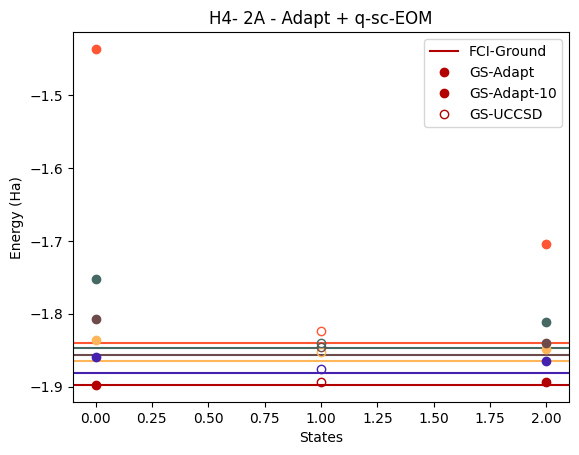

In [ ]:
import matplotlib.pyplot as plt

UCCSD = np.array([-1.894237090527794, -1.87552755, -1.85219672, -1.84612716, -1.84008163, -1.82322033,
        -1.39851009, -1.3819576 , -1.36410544, -1.34656866, -1.34472257,
        -1.34165828, -1.32865824, -1.32657957, -1.30661174, -1.30637266,
        -1.21443845, -1.20437287, -1.19634263, -1.19468623, -1.18909112,
        -1.16148397, -1.15873168, -1.15673085, -0.79680511, -0.37872718,
        -0.37816456])
#Just added 10 Parameters to the Adapt and output is different
eig2A_10 = np.array([-1.8936554798169467, -1.86454307, -1.84806541, -1.84004281, -1.81126979, -1.70394516,
        -1.38062727, -1.36676808, -1.3518425 , -1.348901  , -1.34230717,
        -1.32952433, -1.3056667 , -1.29007437, -1.23958894, -1.23295031,
        -1.22525685, -1.20281344, -1.19733139, -1.18456787, -1.16288852,
        -1.15894787, -1.15298679, -1.13436047, -0.79399151, -0.36985703,
        -0.36880845])

plt.axhline(y=fenergies2A[0], color="#b30000", linestyle='-', label='FCI-Ground')
plt.axhline(y=fenergies2A[1], color="#4421af", linestyle='-')
plt.axhline(y=fenergies2A[2], color="#ffb55a", linestyle='-')
plt.axhline(y=fenergies2A[3], color="#6d4b4b", linestyle='-')
plt.axhline(y=fenergies2A[4], color="#466964", linestyle='-')
plt.axhline(y=fenergies2A[5], color="#FF5733", linestyle='-')


plt.plot(0, eig2A[0],'o', color = '#b30000', label = 'GS-Adapt') 
plt.plot(0, eig2A[1], 'o', color = '#4421af')
plt.plot(0, eig2A[2], 'o', color = '#ffb55a')
plt.plot(0, eig2A[3], 'o', color = '#6d4b4b')
plt.plot(0, eig2A[4], 'o', color = '#466964')
plt.plot(0, eig2A[5], 'o', color = '#FF5733')

plt.plot(2, eig2A_10[0],'o', color = '#b30000', label = 'GS-Adapt-10') 
plt.plot(2, eig2A_10[1], 'o', color = '#4421af')
plt.plot(2, eig2A_10[2], 'o', color = '#ffb55a')
plt.plot(2, eig2A_10[3], 'o', color = '#6d4b4b')
plt.plot(2, eig2A_10[4], 'o', color = '#466964')
plt.plot(2, eig2A_10[5], 'o', color = '#FF5733')

plt.plot(1, UCCSD[0],'o', markerfacecolor = 'None', color = '#b30000', label = 'GS-UCCSD') 
plt.plot(1, UCCSD[1], 'o',  markerfacecolor = 'None',color = '#4421af')
plt.plot(1, UCCSD[2], 'o', markerfacecolor = 'None',color = '#ffb55a')
plt.plot(1, UCCSD[3], 'o', markerfacecolor = 'None',color = '#6d4b4b')
plt.plot(1, UCCSD[4], 'o', markerfacecolor = 'None',color = '#466964')
plt.plot(1, UCCSD[5], 'o', markerfacecolor = 'None',color = '#FF5733')

plt.legend(loc = 'upper right')
plt.xlabel('States')
plt.ylabel('Energy (Ha)')
plt.title('H4- 2A - Adapt + q-sc-EOM')
#plt.ylim(-2,-1.6)

plt.show()